In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import torch.nn as nn
from tqdm import tqdm
import random
from scipy.special import hermite
from math import factorial

# --- Configuração do Dispositivo ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### **Solução Numérica da Equação de Schrödinger para o OHQ via PINNs**

#### **1. Introdução e Objetivo**
A aplicação de Redes Neurais Informadas pela Física (PINNs) representa uma abordagem poderosa na solução de equações diferenciais. Este trabalho explora essa metodologia no contexto de problemas de autovalores, que são cruciais em diversas áreas da ciência. O desafio consiste em utilizar redes neurais de forma não supervisionada para descobrir simultaneamente as autofunções ($\psi$) e os autovalores ($E$) de um sistema.

Para superar limitações de abordagens anteriores, este trabalho implementa a metodologia de Jin et al. (2022), que introduz uma **função de perda de regularização informada pela física**. O objetivo é, portanto, demonstrar a eficácia de uma PINN na resolução da Equação de Schrödinger para o Oscilador Harmônico Quântico (OHQ). As contribuições-chave desta metodologia são: (1) o uso de um parâmetro de rede treinável para a descoberta direta do autovalor; (2) a incorporação de simetrias físicas (paridade) na arquitetura da rede para acelerar a convergência; e (3) a introdução de perdas de normalização ($\mathcal{L}_{\text{norm}}$) e ortogonalidade ($\mathcal{L}_{\text{orto}}$) para guiar a rede na busca sequencial por autoestados fisicamente coerentes.

#### **2. Formulação Matemática**
O problema de autovalor a ser resolvido é a Equação de Schrödinger estacionária:
$$
\hat{H}\psi(x) = E\psi(x)
$$
onde $\hat{H}$ é o operador Hamiltoniano. Para o OHQ, em unidades adimensionais ($\hbar=m=\omega=1$), o Hamiltoniano é dado por:
$$
\hat{H} = -\frac{1}{2}\frac{d^2}{dx^2} + \frac{1}{2}x^2
$$
Assim, a equação diferencial ordinária (EDO) específica é:
$$
-\frac{1}{2}\frac{d^2\psi(x)}{dx^2} + \frac{1}{2}x^2\psi(x) = E\psi(x)
$$
com a condição de contorno $\psi(x) \to 0$ quando $x \to \pm\infty$.

In [7]:
# --- Hiperparâmetros da Rede e Otimizador ---
HIDDEN_SIZE = 100
EPOCHS = 75000
LEARNING_RATE = 1e-2
BETAS = [0.999, 0.9999]

# --- Domínio e Pontos de Colocação ---
DOMINIO_X = [-6, 6]
N_PONTOS = 600
F_BOUNDARY = 0.0

# --- Cronograma de Treinamento ---
# Define as épocas para alternar a busca de estados
EPOCA_INICIO_ESTADO_0 = 0      # Inicia buscando n=0 (par)
EPOCA_INICIO_ESTADO_2 = 15000  # Busca n=2 (par), ortogonal a n=0
EPOCA_INICIO_ESTADO_1 = 35000  # Reinicia e busca n=1 (ímpar)
EPOCA_INICIO_ESTADO_3 = 55000  # Busca n=3 (ímpar), ortogonal a n=1
EPOCAS_BURN_IN = 500 # Épocas a ignorar no início de uma fase antes de salvar o modelo

# --- Constantes Físicas (ħ = m = ω = 1) ---
hbar = 1
m = 1
omega = 1

### 3. Metodologia

##### **3.1 Arquitetura da Rede e *Ansatz***
A autofunção $\psi(x)$ é aproximada por uma rede neural $\psi_{NN}(x, \theta)$, onde $\theta$ representa os pesos e biases treináveis. Para impor as condições de contorno, utilizamos um *ansatz* paramétrico:
$$
\psi(x, E) = f_b + g(x) \cdot \mathcal{N}(x; \theta, E)
$$
onde $\mathcal{N}$ é a saída da rede neural, $f_b=0$ para o OHQ, e $g(x) = (1-e^{-(x-x_{min})})(1-e^{x-x_{max}})$ é uma função de envelope que garante $\psi(x) \to 0$ nos limites do domínio. O autovalor de energia $E$ é tratado como um parâmetro adicional da rede, a ser aprendido durante a otimização.

##### **3.2 Simetria de Paridade**
Dado que o potencial $V(x) = \frac{1}{2}x^2$ é simétrico, as autofunções possuem paridade definida (par ou ímpar). Esta propriedade é embutida na arquitetura da rede para acelerar a convergência, definindo a saída $\mathcal{N}$ como uma combinação de uma sub-rede $\mathcal{N}_1$:
- **Par:** $\mathcal{N}_{par}(x) = \mathcal{N}_1(x) + \mathcal{N}_1(-x)$
- **Ímpar:** $\mathcal{N}_{ímpar}(x) = \mathcal{N}_1(x) - \mathcal{N}_1(-x)$

In [ ]:
class SinAct(torch.nn.Module):
    @staticmethod
    def forward(input): return torch.sin(input)

class PINN1D(torch.nn.Module):
    def __init__(self, D_hid: int):
        super(PINN1D, self).__init__()
        self.actv = SinAct()
        self.parity = 'even'  # A paridade pode ser 'even' ou 'odd'
        self.Lin_E = torch.nn.Linear(1, 1)
        self.Lin_1 = torch.nn.Linear(2, D_hid)
        self.Lin_out = torch.nn.Linear(D_hid, 1)

    def forward(self, x_points, f_b):
        E_tr = torch.abs(self.Lin_E(torch.ones_like(x_points)))
        
        # Entradas para a rede, incluindo a energia como um canal
        input_pos = torch.cat((x_points, E_tr), 1)
        input_neg = torch.cat((-1 * x_points, E_tr), 1)
        
        l1_x = self.Lin_1(input_pos)
        l1_x_neg = self.Lin_1(input_neg)
        
        sin_l1_x = self.actv(l1_x)
        sin_l1_x_neg = self.actv(l1_x_neg)
        
        # Aplica a simetria de paridade
        if self.parity == 'even':
            N_output = self.Lin_out(sin_l1_x + sin_l1_x_neg)
        else: # 'odd'
            N_output = self.Lin_out(sin_l1_x - sin_l1_x_neg)
        
        # Função de envelope g(x)
        g_x = (1 - torch.exp(-(x_points - DOMINIO_X[0]))) * (1 - torch.exp(x_points - DOMINIO_X[1]))
        
        # Ansatz: f(x) = fb + g(x)N(x)
        return f_b + g_x * N_output, E_tr

def df(output, input, order=1):
    """Calcula derivadas usando diferenciação automática."""
    for _ in range(order):
        output = torch.autograd.grad(output, input, torch.ones_like(output), create_graph=True)[0]
    return output

def perturb_points(x, sig=0.5):
    """Adiciona ruído aos pontos de colocação para robustez."""
    delta_x = x[1] - x[0]
    noise = delta_x * torch.randn_like(x) * sig
    perturbed = x + noise
    perturbed[0], perturbed[-1] = x[0], x[-1]
    return perturbed

def permute_points(x):
    """Embaralha os pontos para evitar viés no treinamento."""
    perm_indices = np.random.permutation(len(x))
    perm_x = x[perm_indices]
    perm_x.requires_grad = True
    return perm_x

def potential(x):
    """Potencial do Oscilador Harmônico Quântico."""
    return 0.5 * m * (omega**2) * x**2

##### **3.3 Função de Perda Informada pela Física**
A rede é otimizada minimizando uma função de perda total $L_{\text{total}} = \mathcal{L}_{\text{DE}} + \mathcal{L}_{\text{reg}}$, onde $\mathcal{L}_{\text{reg}} = \mathcal{L}_{\text{norm}} + \mathcal{L}_{\text{orto}}$.

1.  **Perda da Equação Diferencial ($\mathcal{L}_{\text{DE}}$):** Mede o resíduo da Equação de Schrödinger e é definido como o erro quadrático médio:
    $$
    \mathcal{L}_{\text{DE}} = \left\langle \left( \hat{H}\psi(x, E) - E\psi(x, E) \right)^2 \right\rangle_x
    $$

2.  **Perda de Normalização ($\mathcal{L}_{\text{norm}}$):** Evita a solução trivial ($\psi=0$) forçando a norma da autofunção (aproximada por uma soma discreta) a se aproximar de um valor constante.
    $$
     \mathcal{L}_{\text{norm}} = \left( \langle \psi(x, E), \psi(x, E) \rangle - \frac{N}{L_{dom}} \right)^2
    $$
    onde $\langle \cdot, \cdot \rangle$ é o produto escalar discreto, $N$ é o número de pontos de colocação e $L_{dom}$ é o comprimento do domínio.

3.  **Perda de Ortogonalidade ($\mathcal{L}_{\text{orto}}$):** Para encontrar estados excitados $\psi_k$, este termo impõe a condição $\langle \psi_j | \psi_k \rangle = 0$ para $j < k$ e mesma paridade.
    $$
    \mathcal{L}_{\text{orto}} = \sum_{j=1}^{k} \left\langle \psi_{j}, \psi(x, E) \right\rangle^2
    $$
    onde $\psi_j$ são as autofunções já descobertas.

In [ ]:
def L_DE(x, psi, E, V):
    """Calcula a perda da Equação Diferencial (L_DE)."""
    psi_ddx = df(psi, x, 2)
    residual = -0.5 * (hbar**2 / m) * psi_ddx + (V(x) - E) * psi
    return (residual.pow(2)).mean()

def L_norm(x, psi, N_pontos, L_dominio):
    """Calcula a perda de Normalização (L_norm)."""
    norm = torch.sqrt(torch.dot(psi[:, 0], psi[:, 0]))
    target_norm = np.sqrt(N_pontos / L_dominio)
    return ((target_norm - norm) / target_norm).pow(2)

def weights_init(m):
    """Função para reinicializar os pesos da rede."""
    if isinstance(m, nn.Linear) and m.weight.shape[0] != 1:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

def train(num_neurons, num_epochs, lr, betas, dominio_x, n_pontos, f_b):
    pinn = PINN1D(num_neurons).to(DEVICE)
    optimizer = optim.Adam(pinn.parameters(), lr=lr, betas=betas)
    
    histories = {key: [] for key in ['total', 'de', 'norm', 'orto', 'energy']}
    melhores_modelos = {i: (None, 1e20) for i in range(4)}
    
    x_base = torch.linspace(dominio_x[0], dominio_x[1], n_pontos).reshape(-1, 1)
    L_dominio = dominio_x[1] - dominio_x[0]
    
    start_time = time.time()
    
    # --- Adiciona variáveis para rastrear a fase de treinamento ---
    fase_atual = -1
    epoca_inicio_fase = 0
    
    with tqdm(total=num_epochs, desc="Treinamento") as pbar:
        for epoch in range(num_epochs):
            # --- Gerenciamento do Currículo de Treinamento ---
            if epoch >= EPOCA_INICIO_ESTADO_3:
                state_idx, pinn.parity = 3, 'odd'
            elif epoch >= EPOCA_INICIO_ESTADO_1:
                state_idx, pinn.parity = 2, 'odd'
            elif epoch >= EPOCA_INICIO_ESTADO_2:
                state_idx, pinn.parity = 1, 'even'
            else:
                state_idx, pinn.parity = 0, 'even'

            # --- Detecta a mudança de fase ---
            if state_idx != fase_atual:
                fase_atual = state_idx
                epoca_inicio_fase = epoch # Armazena a época de início da fase atual
                melhores_modelos[state_idx] = (None, 1e20) 
                
                if epoch in [EPOCA_INICIO_ESTADO_2, EPOCA_INICIO_ESTADO_1]:
                    pinn.apply(weights_init)

            # --- Forward Pass e Cálculo da Perda ---
            x_colocacao = permute_points(perturb_points(x_base)).to(DEVICE)
            psi, E = pinn(x_colocacao, f_b)
            
            loss_de = L_DE(x_colocacao, psi, E, potential)
            loss_norm = L_norm(x_colocacao, psi, n_pontos, L_dominio)
            
            loss_orto = 0.0
            if state_idx == 1 and melhores_modelos[0][0]:
                psi_n0, _ = melhores_modelos[0][0](x_colocacao, f_b)
                loss_orto = torch.abs(torch.dot(psi_n0[:, 0].detach(), psi[:, 0])) / 25
            elif state_idx == 3 and melhores_modelos[2][0]:
                psi_n1, _ = melhores_modelos[2][0](x_colocacao, f_b)
                loss_orto = torch.abs(torch.dot(psi_n1[:, 0].detach(), psi[:, 0])) / 25
            
            total_loss = loss_de + loss_norm + loss_orto

            # --- Otimização ---
            optimizer.zero_grad()
            total_loss.backward(retain_graph=False)
            optimizer.step()

            if (epoch - epoca_inicio_fase > EPOCAS_BURN_IN):
                if loss_de.item() < melhores_modelos[state_idx][1]:
                    melhores_modelos[state_idx] = (copy.deepcopy(pinn), loss_de.item())
            
            for key, val in zip(histories.keys(), [total_loss, loss_de, loss_norm, loss_orto, E[0]]):
                histories[key].append(val.item() if torch.is_tensor(val) else val)
            
            pbar.set_postfix({
                'Época': epoch, 
                'Perda': f'{total_loss.item():.4e}', 
                'Energia': f'{E[0].item():.4f}',
                'Estado': state_idx
            })
            pbar.update(1)

    return melhores_modelos, histories, time.time() - start_time

In [5]:
melhores_modelos, historico_perdas, runTime = train(
    num_neurons=HIDDEN_SIZE, 
    num_epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    betas=BETAS,
    dominio_x=DOMINIO_X, 
    n_pontos=N_PONTOS, 
    f_b=F_BOUNDARY
)
print(f"\nTreinamento concluído em {runTime:.2f} segundos.")

Treinamento: 100%|██████████| 75000/75000 [14:38<00:00, 85.38it/s, Época=74999, Perda=8.5865e-03, Energia=3.5000, Estado=3] 


Treinamento concluído em 878.40 segundos.


### 4. Resultados e Discussão
A eficácia do modelo foi avaliada pela análise da convergência da energia e pela comparação das autofunções obtidas com as soluções analíticas do OHQ.

O histórico da energia (gráfico esquerdo) mostra a formação de platôs estáveis que convergem para os autovalores teóricos $E_n = n + 1/2$ (linhas tracejadas), indicando o sucesso da rede em encontrar os níveis de energia. A transição entre os platôs ocorre nas épocas definidas no cronograma, quando a perda de ortogonalidade é ativada e a paridade da rede é trocada, forçando o modelo a buscar o próximo autoestado. O histórico da perda total (gráfico direito) diminui consistentemente, validando a estabilidade da otimização.

As energias e autofunções finais, extraídas dos modelos com menor perda em cada fase, demonstram excelente concordância com os valores teóricos e as funções de onda analíticas, baseadas nos polinômios de Hermite. Isso confirma que a PINN, guiada pelas perdas físicas e pela simetria embutida, encontrou soluções corretas e significativas.

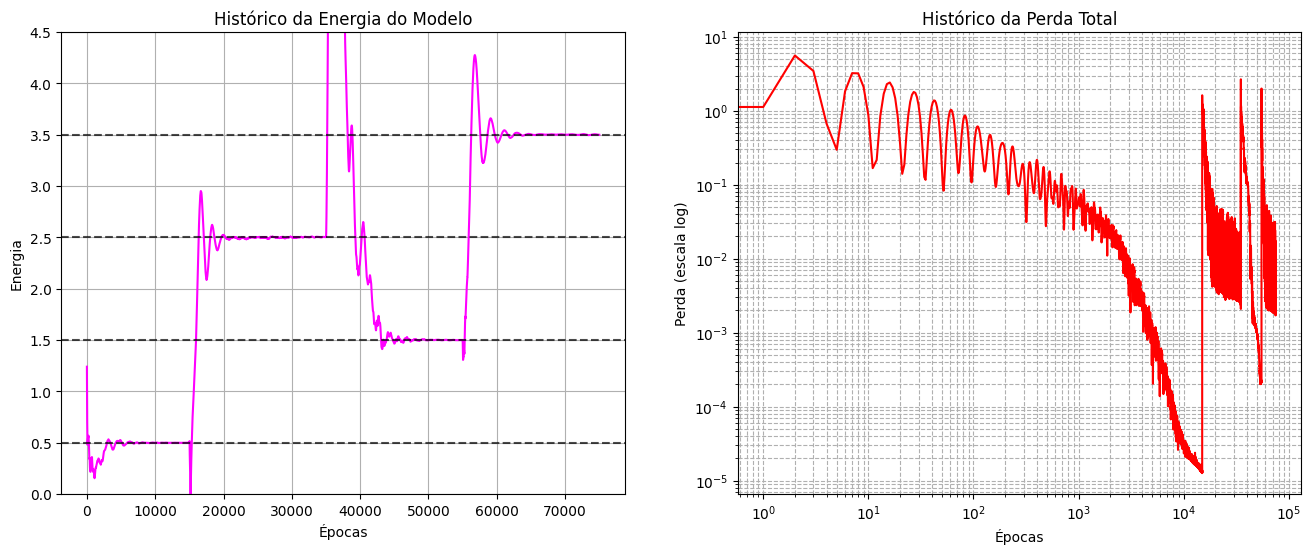


--- Energias Finais Encontradas ---
Estado n=0 | Energia: 0.4998 | (Armazenado no índice 0)
Estado n=1 | Energia: 1.5000 | (Armazenado no índice 2)
Estado n=2 | Energia: 2.5042 | (Armazenado no índice 1)
Estado n=3 | Energia: 3.5000 | (Armazenado no índice 3)


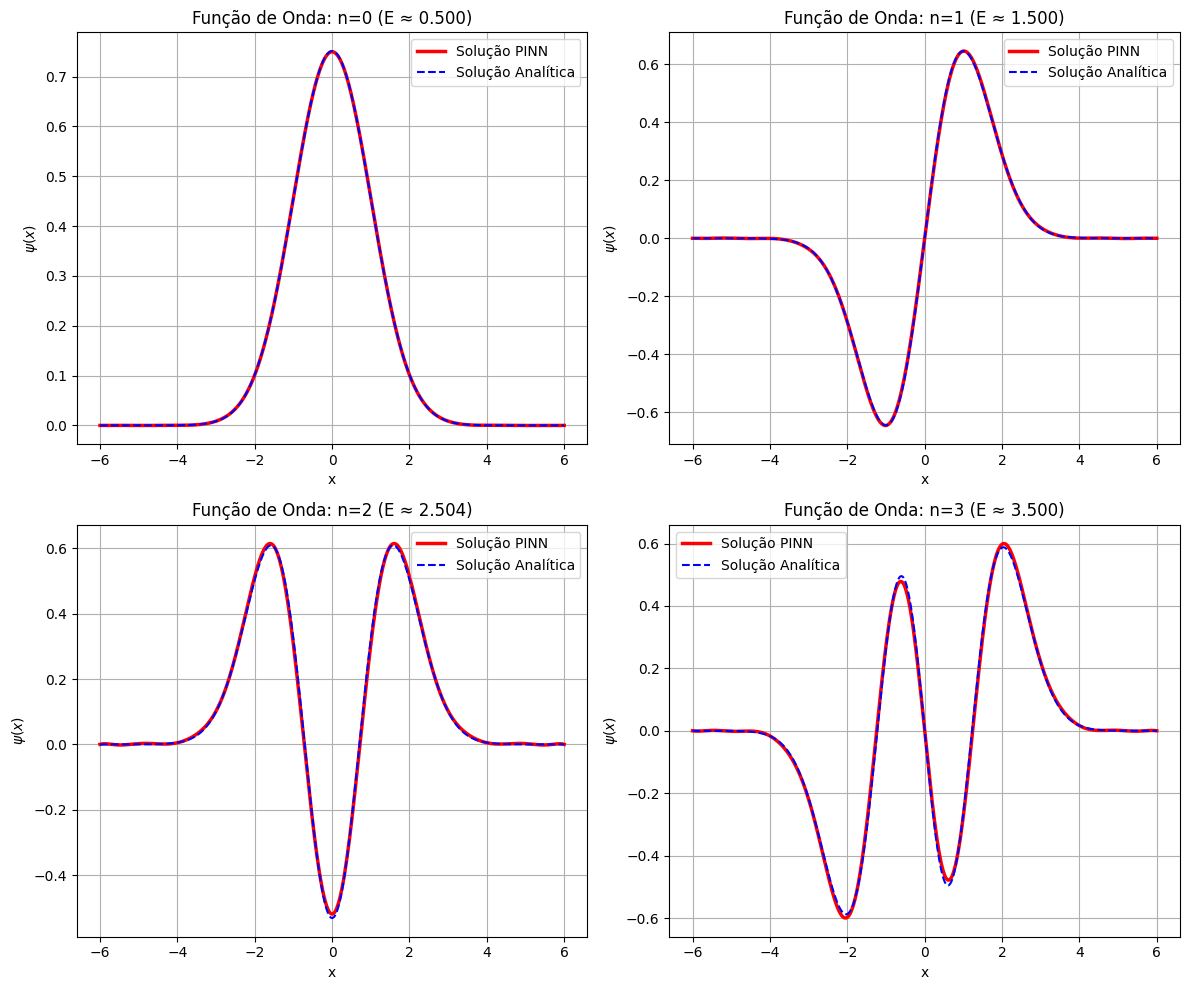

In [8]:
# --- Análise Gráfica da Convergência ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(historico_perdas['energy'], color='magenta')
ax1.set_title('Histórico da Energia do Modelo')
ax1.set_xlabel('Épocas'); ax1.set_ylabel('Energia')
THEORETICAL_ENERGIES = [(n + 0.5) for n in range(4)]
for E_n in THEORETICAL_ENERGIES: ax1.axhline(y=E_n, linestyle='--', color='black', alpha=0.7)
ax1.set_ylim(0, max(THEORETICAL_ENERGIES) + 1); ax1.grid(True)
ax2.loglog(historico_perdas['total'], color='red')
ax2.set_title('Histórico da Perda Total'); ax2.set_xlabel('Épocas')
ax2.set_ylabel('Perda (escala log)'); ax2.grid(True, which="both", ls="--")
plt.show()

# --- Função para a Solução Analítica ---
def analytical_wavefunction_qho(n, x_tensor):
    x_np = x_tensor.cpu().numpy().flatten()
    norm_factor = 1.0 / np.sqrt(2**n * factorial(n)) * (m * omega / (np.pi * hbar))**0.25
    hermite_poly = hermite(n)(np.sqrt(m * omega / hbar) * x_np)
    gaussian = np.exp(-m * omega / (2 * hbar) * x_np**2)
    return norm_factor * hermite_poly * gaussian

# --- Plotagem das Funções de Onda ---
x_plot = torch.linspace(DOMINIO_X[0], DOMINIO_X[1], N_PONTOS).reshape(-1, 1).to(DEVICE)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
ordem_indices_plotagem = [0, 2, 1, 3] 

print("\n--- Energias Finais Encontradas ---")
for n, storage_idx in enumerate(ordem_indices_plotagem):
    model_tuple = melhores_modelos[storage_idx]
    
    if model_tuple[0] is not None:
        model = model_tuple[0]
        psi, E = model.to(DEVICE)(x_plot, F_BOUNDARY)
        energy_val = E[0].item()
        print(f"Estado n={n} | Energia: {energy_val:.4f} | (Armazenado no índice {storage_idx})")
        
        psi_np = psi.cpu().data.numpy().flatten()
        integral_psi_sq = np.trapz(psi_np**2, x=x_plot.cpu().numpy().flatten())
        psi_norm_pinn = psi_np / np.sqrt(integral_psi_sq)

        # Para n=0 e n=2 (pares), o pico de maior valor absoluto deve ser positivo.
        if n == 0 or n == 2:
            max_abs_idx = np.argmax(np.abs(psi_norm_pinn))
            if np.sign(psi_norm_pinn[max_abs_idx]) < 0:
                psi_norm_pinn *= -1
        
        # Para n=1 e n=3 (ímpares), o primeiro pico principal (em x>0) deve ser positivo.
        elif n == 1 or n == 3:
            # Encontra o índice do máximo absoluto no lado positivo do domínio
            positive_x_indices = np.where(x_plot.cpu().numpy().flatten() > 0.1)[0]
            if len(positive_x_indices) > 0:
                max_abs_idx_pos = positive_x_indices[np.argmax(np.abs(psi_norm_pinn[positive_x_indices]))]
                if np.sign(psi_norm_pinn[max_abs_idx_pos]) < 0:
                    psi_norm_pinn *= -1

        psi_norm_analytical = analytical_wavefunction_qho(n, x_plot)

        ax = axes[n]
        ax.plot(x_plot.cpu().numpy(), psi_norm_pinn, color='red', linewidth=2.5, label='Solução PINN')
        ax.plot(x_plot.cpu().numpy(), psi_norm_analytical, color='blue', linestyle='--', label='Solução Analítica')
        ax.set_title(f'Função de Onda: n={n} (E ≈ {energy_val:.3f})')
        ax.set_xlabel('x'); ax.set_ylabel(r'$\psi(x)$'); ax.grid(True)
        ax.legend()

plt.tight_layout()
plt.show()